Link Database:

https://drive.google.com/drive/folders/10sjxvSM6pPncywQGiQnXXliMcpVozc2Q?usp=sharing

Link Model:

https://drive.google.com/file/d/1SrgdmodIT1dj-V3WVPsGI6GaoQOCKeTc/view?usp=sharing

Link Directory untuk Flask:

https://drive.google.com/drive/folders/1dAipD3oS4C0DcPDL8HNOi2XQ4CElYI1S?usp=sharing


# **Parsing Anotasi dan Memuat Data**

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Path ke dataset di Google Drive
data_dir = '/content/drive/MyDrive/Colab Notebooks/src/Datasets/Face Detection'


Mounted at /content/drive


In [ ]:
import os
import xml.etree.ElementTree as ET
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

# Fungsi untuk mem-parsing anotasi XML
def parse_annotation_object(annotation_object):
    params = {}
    for param in list(annotation_object):
        if param.tag == 'name':
            params['name'] = param.text
        if param.tag == 'bndbox':
            for coord in list(param):
                params[coord.tag] = int(coord.text)
    return params

# Parsing seluruh anotasi menjadi DataFrame
def load_annotations(image_dir, annotation_dir):
    dataset = []
    for annotation_file in os.listdir(annotation_dir):
        tree = ET.parse(os.path.join(annotation_dir, annotation_file))
        root = tree.getroot()
        constants = {'file': root.find('filename').text[0:-4]}
        objects = root.findall('object')
        for obj in objects:
            object_params = parse_annotation_object(obj)
            dataset.append({**constants, **object_params})
    return pd.DataFrame(dataset)

# Path gambar dan anotasi
image_dir = os.path.join(data_dir, 'images')
annotation_dir = os.path.join(data_dir, 'annotations')

# Load anotasi
df = load_annotations(image_dir, annotation_dir)
df.shape

(4072, 6)

In [ ]:
df.head()

,file,name,xmin,ymin,xmax,ymax
0,maksssksksss10,with_mask,98,267,194,383
1,maksssksksss0,without_mask,79,105,109,142
2,maksssksksss0,with_mask,185,100,226,144
3,maksssksksss0,without_mask,325,90,360,141
4,maksssksksss100,with_mask,189,30,245,88


In [ ]:
df["name"].value_counts()

,count
name,
with_mask,3232
without_mask,717
mask_weared_incorrect,123


Text(0, 0.5, 'name')

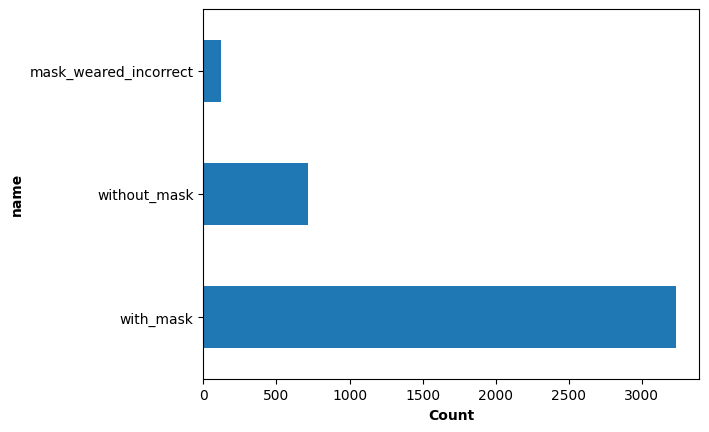

In [ ]:
df["name"].value_counts().plot(kind='barh')
plt.xlabel('Count', fontsize = 10, fontweight = 'bold')
plt.ylabel('name', fontsize = 10, fontweight = 'bold')

**Crop Gambar Berdasarkan Bounding Box**

In [ ]:
# Fungsi untuk cropping gambar berdasarkan bounding box
def crop_img(image_path, x_min, y_min, x_max, y_max):
    img = Image.open(image_path)
    cropped = img.crop((x_min - (x_max - x_min) * 0.1, y_min - (y_max - y_min) * 0.1, x_max + (x_max - x_min) * 0.1, y_max + (y_max - y_min) * 0.1))
    return cropped

# Simpan gambar hasil cropping
def save_image(image, output_dir, image_name, label):
    label_dir = os.path.join(output_dir, label)
    os.makedirs(label_dir, exist_ok=True)
    image.save(os.path.join(label_dir, f"{image_name}.png"))


# **Preprocessing Data**

***Splitting Data***

In [ ]:
# Bagi dataset menjadi train, val, dan test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Proses dan simpan gambar untuk setiap subset
for subset, subset_df in [('train', train_df), ('val', val_df), ('test', test_df)]:
    subset_dir = os.path.join(output_dir, subset)

    for _, row in subset_df.iterrows():
        # Buat path untuk file output
        output_path = os.path.join(subset_dir, f"{row['name']}", f"{row['file']}.png")

        # Cek apakah gambar sudah ada
        if not os.path.exists(output_path):
            # Jika belum ada, proses gambar
            image_path = os.path.join(image_dir, f"{row['file']}.png")
            cropped_img = crop_img(image_path, row['xmin'], row['ymin'], row['xmax'], row['ymax'])
            save_image(cropped_img, subset_dir, row['file'], row['name'])

print("Semua gambar telah diprocessed")

Semua gambar telah diprocessed


***Augmentasi Data***

In [ ]:
# Augmentasi data
datagen = ImageDataGenerator(
    rescale=1.0/255,
    horizontal_flip=True,
    zoom_range=0.1,
    shear_range=0.2,
    rotation_range=4,
    vertical_flip=False
)

# Data generator untuk validasi
val_datagen = ImageDataGenerator(rescale=1.0/255)


# **Arsitektur CNN**

In [ ]:
# Arsitektur CNN
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(35, 35, 3)),
    MaxPooling2D(pool_size=2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=2),
    Dropout(0.3),
    Flatten(),
    Dense(500, activation='relu'),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

# Compile model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']
)


# **Training Model**

In [ ]:
# Path ke subset train, val, dan test
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')

# Generator data
train_generator = datagen.flow_from_directory(
    directory=train_dir, target_size=(35, 35), class_mode="categorical", batch_size=8
)
val_generator = val_datagen.flow_from_directory(
    directory=val_dir, target_size=(35, 35), class_mode="categorical", batch_size=8
)
test_generator = val_datagen.flow_from_directory(
    directory=test_dir, target_size=(35, 35), class_mode="categorical", batch_size=8
)

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
lrr = ReduceLROnPlateau(monitor='val_loss',patience=8,verbose=1,factor=0.5, min_lr=0.00001)

# Training
model_history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping, lrr]
)


Found 950 images belonging to 3 classes.
Found 404 images belonging to 3 classes.
Found 471 images belonging to 3 classes.
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


119/119 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step - AUC: 0.8198 - Precision: 0.7102 - Recall: 0.5346 - accuracy: 0.6243 - loss: 1.9116 - val_AUC: 0.9747 - val_Precision: 0.9010 - val_Recall: 0.8787 - val_accuracy: 0.8886 - val_loss: 0.4364 - learning_rate: 0.0010
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - AUC: 0.9569 - Precision: 0.8952 - Recall: 0.8545 - accuracy: 0.8718 - loss: 0.4892 - val_AUC: 0.9676 - val_Precision: 0.9011 - val_Recall: 0.8119 - val_accuracy: 0.8762 - val_loss: 0.4918 - learning_rate: 0.0010
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 19s 72ms/step - AUC: 0.9611 - Precision: 0.9047 - Recall: 0.8461 - accuracy: 0.8697 - loss: 0.4328 - val_AUC: 0.9868 - val_Precision: 0.9410 - val_Recall: 0.9084 - val_accuracy: 0.9307 - val_loss: 0.2707 - learning_rate: 0.0010
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - AUC: 0.9733 - Precision: 0.9130 - Recall: 0.8805 - accuracy: 0.8959 - loss: 0.3493 - val_AUC: 0.9890 - val_Precision: 0.9409 - val_Recall: 0.9059 - val_

# **Evaluasi**

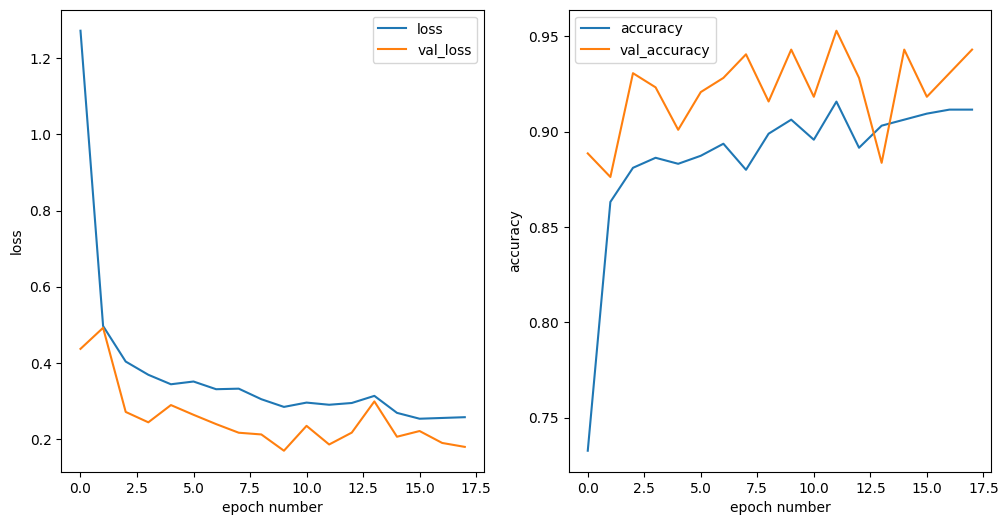

In [ ]:
def graph_loss_and_accuracy(history):
    history_df = pd.DataFrame(history)
    fig, ax = plt.subplots(1,2, figsize=(12, 6))

    history_df.loc[0:, ['loss', 'val_loss']].plot(ax=ax[0])
    ax[0].set(xlabel = 'epoch number', ylabel = 'loss')

    history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=ax[1])
    ax[1].set(xlabel = 'epoch number', ylabel = 'accuracy')

graph_loss_and_accuracy(model_history.history)

In [ ]:
# Evaluating the model
model_loss, model_acc, recall, precision, auc = model.evaluate(test_generator)
print(f'{model_loss} || {model_acc*100} || {recall*100} || {precision*100} || {auc*100}')

59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - AUC: 0.9909 - Precision: 0.9626 - Recall: 0.9427 - accuracy: 0.9494 - loss: 0.1655
0.1873047798871994 || 94.69214677810669 || 93.84288787841797 || 95.87852358818054 || 98.96896481513977


In [ ]:
# Simpan model ke Google Drive
model.save('/content/drive/MyDrive/Colab Notebooks/UAS/my_model.h5')
model.save('/content/drive/MyDrive/Colab Notebooks/UAS/my_model.keras')


# **Pengujian Model**

59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
with_mask || with_mask


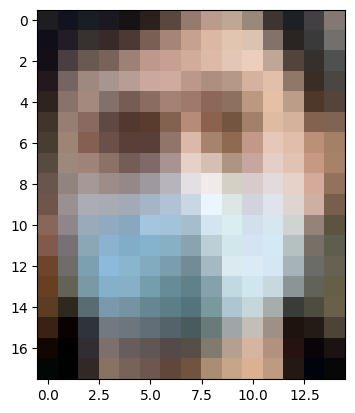

In [ ]:
import cv2

paths = test_generator.filenames
y_pred = model.predict(test_generator).argmax(axis=1)
classes = test_generator.class_indices

a_img_rand = np.random.randint(0,len(paths))
img = cv2.imread(os.path.join(output_dir,'test', paths[a_img_rand]))
colored_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

plt.imshow(colored_img)
true_label = paths[a_img_rand].split('/')[0]
predicted_label = list(classes)[y_pred[a_img_rand]]
print(f'{predicted_label} || {true_label}')

# **Prediksi Dengan Input Data Baru**

**Load Model (jika model sudah dibuat)**

In [ ]:
from tensorflow.keras.models import load_model

# Muat model
model = load_model("/content/drive/MyDrive/Colab Notebooks/UAS/my_model.keras")


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Saving 41a44b83783f6049b7e439cb8a48cab7.jpg to 41a44b83783f6049b7e439cb8a48cab7.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
Predicted Class: Without Mask
Confidence: 0.95


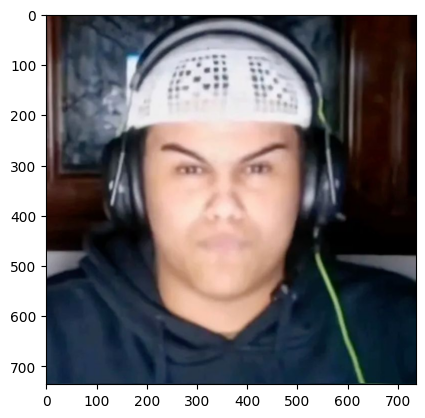

In [ ]:
import numpy as np  # Manipulasi array
from PIL import Image  # Pemrosesan gambar
import matplotlib.pyplot as plt  # Menampilkan gambar
from google.colab import files  # Unggah file
import io  # Buffer untuk file unggahan
import tensorflow as tf  # Prediksi model

class_names = ["Mask Weared Incorrectly", "With Mask", "Without Mask"]

# Unggah file gambar
uploaded = files.upload()

# Ambil nama file dari file yang diunggah
file_name = list(uploaded.keys())[0]

img = Image.open(io.BytesIO(uploaded[file_name]))
plt.imshow(img)

# Lakukan preprocessing yang sama seperti sebelum prediksi
image = img.resize((35, 35))
image_array = np.array(image) / 255.0  # Normalisasi
image_array = np.expand_dims(image_array, axis=0)  # Tambahkan batch dimension

# Melakukan prediksi
predictions = model.predict(image_array)
predicted_class = class_names[np.argmax(predictions)]  # Indeks kelas yang diprediksi
confidence = np.max(predictions)  # Confidence level


print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence:.2f}")



**Penerapan interface dengan API**



In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
import gradio as gr

class_names = ["Mask Weared Incorrectly", "With Mask", "Without Mask"]
# Fungsi prediksi
def predict_image(image):
    # Pastikan gambar adalah format PIL.Image
    if not isinstance(image, Image.Image):
        image = Image.fromarray(np.uint8(image))  # Konversi array NumPy ke PIL Image

    # Ubah gambar ke RGB (jika perlu)
    image = image.convert("RGB")

    # Resize gambar menjadi (35, 35)
    resized_image = image.resize((35, 35))

    # Konversi gambar ke array NumPy
    image_array = np.array(resized_image, dtype=np.float32) / 255.0  # Normalisasi

    # Tambahkan dimensi batch untuk model
    image_array = np.expand_dims(image_array, axis=0)

    # Prediksi
    predictions = model.predict(image_array)
    predicted_class = class_names[np.argmax(predictions)]  # Kelas dengan probabilitas tertinggi
    confidence = np.max(predictions)  # Confidence level

    return f"Class: {predicted_class}, Confidence: {confidence:.2f}"
# Antarmuka Gradio
interface = gr.Interface(
    fn=predict_image,  # Fungsi prediksi
    inputs=gr.Image(),  # Input berupa gambar
    outputs="text",  # Output berupa teks
    title="Image Prediction",
    description="Upload an image to get its predicted class and confidence."
)

# Jalankan aplikasi Gradio
interface.launch(debug=True)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://512413efb2f581abab.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
